# ULMFiT + Siamese Network for Sentence Vectors
## Part Two: Pretraining
This notebook will build a language model from lesson 10 of the Fast ai course and retrain it on the SNLI dataset. 


In [1]:
from fastai.text import *
import html

import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
import data

snli_root = './data/SNLI/'

## Load the tokens from the SNLI data

In [2]:
#load the results so we can pick it up from here 
itos = pickle.load(open(f'{snli_root}itos.pkl', 'rb'))
trn_lm = np.load(f'{snli_root}trn_lm.npy')
val_lm = np.load(f'{snli_root}val_lm.npy')

stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
vocab_size

34155

In [3]:
# check to make sure that the data looks ok
for word in trn_lm[:100]:
    print(itos[word], end=" ")

x_bos the young woman is drawing pictures of plants . x_bos a woman in a black shirt holding a cherry pie on top of her head , the pie is still in the baking dish . x_bos snowboarder jumps off rail over snowpile . x_bos a man in a hat riding a bucking horse . x_bos two people sitting in the dark near a blazing fire . x_bos a man wearing a helmet and sunglasses smiles . x_bos the man is painted . x_bos the workers are at work . x_bos someone is on a train . x_bos the woman 

## Load the Wikitext LM and fix the weights

In [12]:
#download the wikitext LM
# ! wget -nH -r -np -P ./data/aclImdb/ http://files.fast.ai/models/wt103/

In [4]:
#these are the values used for the original LM
em_sz,nh,nl = 400,1150,3
PATH = Path('./data/aclImdb')
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [9]:
#get the mean weight value for any new vocab
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load(Path(PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

#fill in the missing values from the old vocab
new_w = np.zeros((vocab_size, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m
    
#fix up the wgts with the new values
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [5]:
max_seq = 20*70
wd = 1e-7
bptt = 70
batch_size = 32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(trn_lm, batch_size, bptt)
val_dl = LanguageModelLoader(val_lm, batch_size, bptt)
md = LanguageModelData(PATH, 1, vocab_size, trn_dl, val_dl, bs=batch_size, bptt=bptt)

### Create the language model and load the weigths

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

learner.model.load_state_dict(wgts)

In [ ]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

In [9]:
learner.save('snli_language_model')

In [8]:
learner.load('snli_language_model')
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

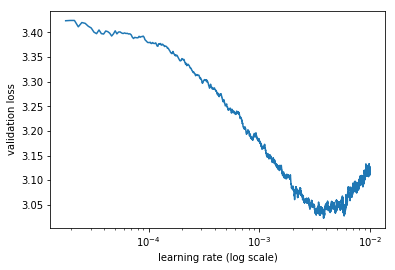

In [12]:
learner.sched.plot()

In [12]:
lrs=1e-2
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy   
    0      3.039858   2.913757   0.424656  
    1      3.038702   2.911905   0.425376  
    2      2.957788   2.834057   0.435456  
    3      2.909908   2.777903   0.444092  
    4      2.862018   2.726461   0.452585  
    5      2.815083   2.683201   0.46055   
    6      2.783773   2.646992   0.467466  
    7      2.729464   2.607094   0.475257  
 35%|███▍      | 1955/5600 [03:03<05:42, 10.64it/s, loss=2.7]

KeyboardInterrupt: 

In [13]:
torch.save(learner.model, "SNLI_LM.pt")